In [1]:
# importing all necessary packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.image as mpimg
%matplotlib inline
import glob
from moviepy.editor import VideoFileClip

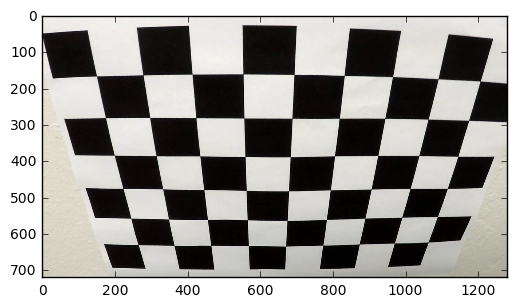

In [2]:
# Reading all images for the camera-calibration in and showing an example of an image.
flipping = 1

images = glob.glob('/media/frank/Zusatz/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
img = mpimg.imread('/media/frank/Zusatz/CarND-Advanced-Lane-Lines/camera_cal/calibration2.jpg')
plt.imshow(img)

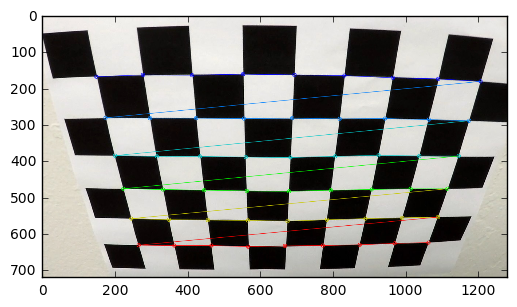

In [3]:
# Finding the Chessboardcorners and printing image from with marked corners
# Code partly adopted from the lesson
objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)
    
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    plt.imshow(img)

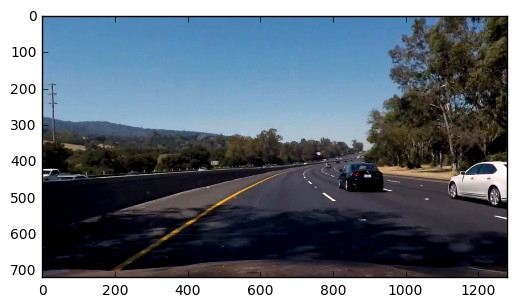

In [4]:
# Using all chessboard images and their corners to calibrate the camera
# Testing the calibration on a lane picture
# I used my code, I generated in the lessons, for the the following functions
objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images:
    
    img = mpimg.imread(fname)
    img_flip = cv2.flip(img, 1)

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray_flip = cv2.cvtColor(img_flip,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    ret_flip, corners_flip = cv2.findChessboardCorners(gray_flip, (9,6), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Assumming the images are roughly symmetric vertically to get more images and achieve a better result
        if (flipping == 1):
            imgpoints.append(corners_flip)
            objpoints.append(objp)
    
        img = cv2.drawChessboardCorners(img_flip, (9,6), corners_flip, ret)
        plt.imshow(img)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

test_string = '/media/frank/Zusatz/CarND-Advanced-Lane-Lines/test_images/test7.png'

test = mpimg.imread(test_string)

if test_string.endswith('.png'):
    test = cv2.convertScaleAbs(test*255)

undist = cv2.undistort(test, mtx, dist)

plt.imshow(undist)

In [5]:
# Define a dir_threshold-function
def dir_threshold(img, sobel_kernel=3, thresh=(0.5, 1.5)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    sobel_dir = np.arctan2(abs_sobelx, abs_sobely)
    
    sbinary = np.zeros_like(sobel_dir)
    sbinary[(sobel_dir >= thresh[0]) & (sobel_dir <= thresh[1])] = 1
    
    return sbinary

In [6]:
# Define a mag_threshold-function
def mag_threshold(img, sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    sobel_mag = np.sqrt(sobelx**2+sobely**2)
    
    scale_factor = np.max(sobel_mag)/255
    
    scaled_sobel = (sobel_mag/scale_factor).astype(np.uint8)
    
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sbinary

In [7]:
# Define a hls_threshold-function - using the s_channel
def hls_threshold(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    sbinary = np.zeros_like(s_channel)
    sbinary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return sbinary

In [8]:
# Define a second hls_threshold-function - using the l_channel
def hls_threshold2(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    
    lbinary = np.zeros_like(l_channel)
    lbinary[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    
    return lbinary

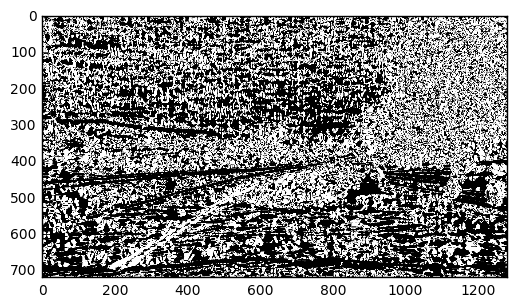

In [9]:
# Plotting the results for each threshold-function and choosing appropriate parameters
# Tried a lot of different parameters to get things right
dir_image = dir_threshold(undist, sobel_kernel=17, thresh=(0.4, 1.4))
plt.imshow(np.asarray(dir_image), cmap='gray')

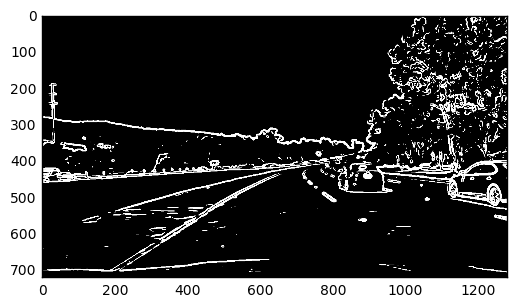

In [10]:
mag_image = mag_threshold(undist, sobel_kernel=13, thresh=(35, 255))
plt.imshow(np.asarray(mag_image), cmap='gray')

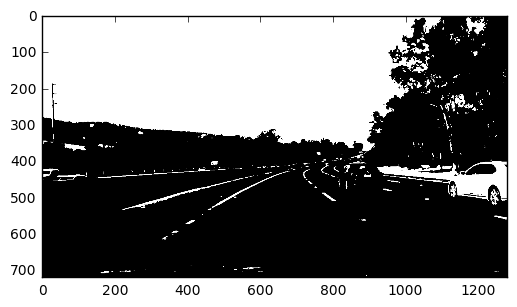

In [11]:
hls2_image = hls_threshold2(undist, thresh=(100, 255))
plt.imshow(np.asarray(hls2_image), cmap='gray')

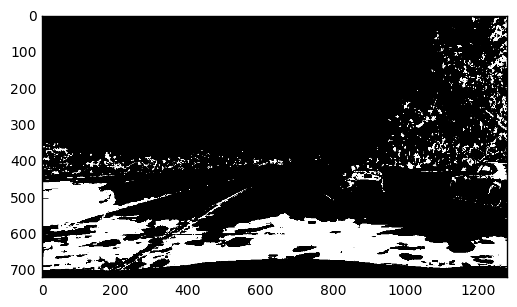

In [12]:
hls_image = hls_threshold(undist, thresh=(150, 255))
plt.imshow(np.asarray(hls_image), cmap='gray')

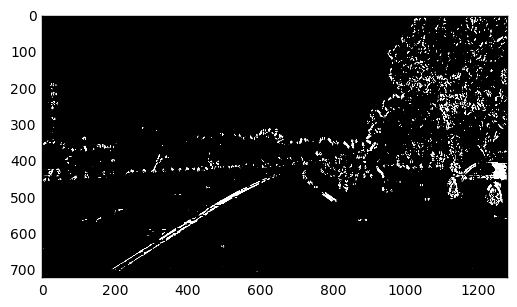

In [13]:
# Combining all threshold-functions to get a combined binary_image
# with (dir_img & mag_img) | (s_img & l_img)
combined = np.zeros_like(dir_image)
combined[((dir_image == 1) & (mag_image == 1)) | (hls_image == 1) & (hls2_image == 1)] = 1
plt.imshow(np.asarray(combined), cmap='gray')

In [14]:
# Warping the picture to get a bird's eye view image
# This involved a bit trial and error to choose a good src-variable
gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
img_size = (gray.shape[1], gray.shape[0])
src = np.float32([[200,img_size[1]],[1113, img_size[1]],[724, 475],[559,475]])
dst = np.float32([[250,img_size[1]],[img_size[0]-250, img_size[1]], [img_size[0]-250, 0], [250, 0]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(combined, M, img_size, flags = cv2.INTER_LINEAR)

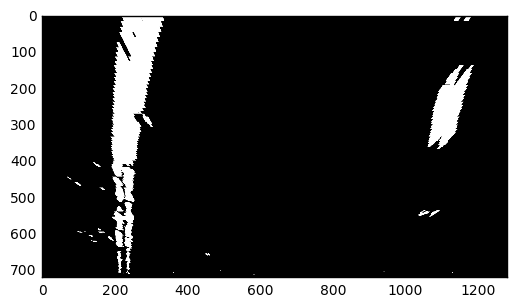

In [15]:
# Plotting the binary bird's eye view picture
plt.imshow(warped, cmap='gray')
binary = np.where(warped>0)
warped[binary] = 1

In [16]:
# printing the undistorted image with the choosen src-variable as a box in the picture
undist_area = np.copy(undist)
area = np.array(src, np.int32)
area = area.reshape((-1,1,2))
undist_area = cv2.polylines(undist_area, [area], True, (0,255,255), 3)

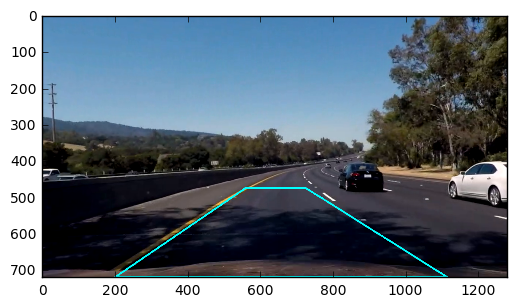

In [17]:
plt.imshow(undist_area)

In [18]:
# The core of the implementation
# Defining a function to search for the lanelines in the binary bird's eye view picture
# Parts of this are from the lessons before the project
def Search_lines_with_histogram(img):
    # Using two histograms to weighting the lower 1/4 higher than the rest of 
    # the lower half to find the starting point of the lanes
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    histogram_bottom = np.sum(img[img.shape[0]/(4/3):,:], axis=0)
    histogram = histogram + histogram_bottom
    
    out_img = np.dstack((img, img, img))*255
    out_img = cv2.convertScaleAbs(out_img)
    
    # Using the midpoint to get a left and right-side histogram
    midpoint = np.int(histogram.shape[0]/2)
    left_hist = histogram[:(midpoint-200)]
    right_hist = histogram[(midpoint+200):]
    
    # I did not just choose the argmax in the left and right histogram to get my starting point, because this
    # wasn't working as stable as I hoped. So instead I searching for the max value and all values >= 0.7 * max_value
    # Then I averaged the position of this values to get my starting point
    left_max = np.max(left_hist)
    right_max = np.max(right_hist)

    left_ind = np.where(left_hist > 0.7*left_max)
    left_high = left_hist[left_ind]
    leftx_base = int((np.sum(left_ind * left_high))/(np.sum(left_high)))
    
    right_ind = np.where(right_hist > 0.7*right_max)
    right_high = right_hist[right_ind]
    rightx_base = int((np.sum(right_ind * right_high))/(np.sum(right_high))+ midpoint+200)
    
    #Building my stacking windows
    nwindows = 9
    window_height = np.int(img.shape[0]/nwindows)

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    # Choosing the margin (therefore the width of the windows) and the minimal number of pixels to move the windows
    margin = 100
    minpix = 300

    left_lane_inds = []
    right_lane_inds = []
    
    # Mostly code from the lessons to setting my windows width, heigth and searching for the line in the windows
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        cv2.rectangle(out_img,(win_xleft_low, win_y_low),(win_xleft_high, win_y_high), (0,255,0),2)
        cv2.rectangle(out_img,(win_xright_low, win_y_low),(win_xright_high, win_y_high), (0,255,0),2)
    
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # return the key_values of the function
    return left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, out_img

In [19]:
# Defining a function to show all information found in the function before by plotting the image
def Draw_lines_with_histogram(img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, out_img):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    mid_fitx = ((left_fit[0]+right_fit[0])/2)*ploty**2+((left_fit[1]+right_fit[1])/2)*ploty+((left_fit[2]+right_fit[2])/2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.plot(mid_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

/media/frank/Zusatz/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/media/frank/Zusatz/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


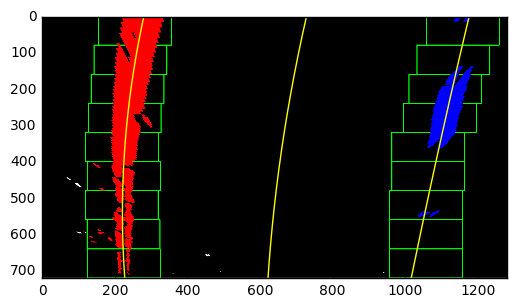

In [20]:
# Using booth functions an the test image
img_hist = Search_lines_with_histogram(warped)
Draw_lines_with_histogram(warped, img_hist[0], img_hist[1], img_hist[2], img_hist[3], img_hist[4], img_hist[5], img_hist[6])

In [21]:
# Defining a function to search for the lanelines in the binary bird's eye view picture
# Instead of using a histogram, we use information from the last good picture in the video
# (for testing purposes we are just using the same picture in the next cells)
# Parts of this are from the lessons before the project
def Search_lines_with_image(img, left_fit, right_fit, nonzerox, nonzeroy):

    # Using the lane-line information from 'img' to search in a certain margin around them
    out_img = np.dstack((img, img, img))*255
    out_img = cv2.convertScaleAbs(out_img)
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_prev = left_fit.copy()
    right_fit_prev = right_fit.copy()

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # return the key_values of the function
    return left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, out_img, left_fit_prev, right_fit_prev

In [22]:
# Defining a function to show all information found in the function before by plotting the image
def Draw_lines_with_image(img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, out_img,left_fit_prev, right_fit_prev):

    margin = 100
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx_prev = left_fit_prev[0]*ploty**2 + left_fit_prev[1]*ploty + left_fit_prev[2]
    right_fitx_prev = right_fit_prev[0]*ploty**2 + right_fit_prev[1]*ploty + right_fit_prev[2]
   
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    mid_fitx = ((left_fit[0]+right_fit[0])/2)*ploty**2+((left_fit[1]+right_fit[1])/2)*ploty+((left_fit[2]+right_fit[2])/2)
    
    window_img = np.zeros_like(out_img)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx_prev-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx_prev+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx_prev-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx_prev+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.plot(mid_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

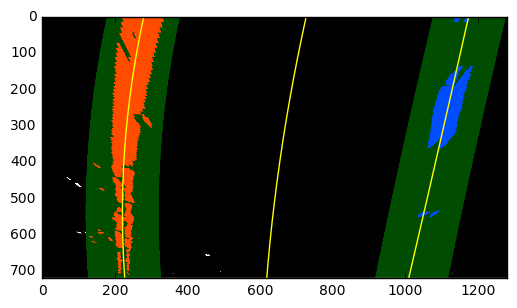

In [23]:
# Using booth functions an the test image
img_img = Search_lines_with_image(warped, img_hist[0], img_hist[1], img_hist[2], img_hist[3])
Draw_lines_with_image(warped, img_img[0], img_img[1], img_img[2], img_img[3], img_img[4], img_img[5], img_img[6], img_img[7], img_img[8])

In [24]:
# Drawing all necessary information on the image and warping it back to the normal perspective
# Furthermore checking if the picture is ok with a sanity-check 
test_1 = np.dstack((warped, warped, warped))*255
test_1 = cv2.convertScaleAbs(test_1)

ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = img_hist[0][0]*ploty**2 + img_hist[0][1]*ploty + img_hist[0][2]
right_fitx = img_hist[1][0]*ploty**2 + img_hist[1][1]*ploty + img_hist[1][2]
mid_fitx = ((img_hist[0][0]+img_hist[1][0])/2)*ploty**2+((img_hist[0][1]+img_hist[1][1])/2)*ploty+((img_hist[0][2]+img_hist[1][2])/2)

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Plotting the middle-lane (average between left and right lane) on the picture and a little red line to show the real
# mid of the picture
mid_window1 = np.array([np.transpose(np.vstack([mid_fitx-4, ploty]))])
mid_window2 = np.array([np.flipud(np.transpose(np.vstack([mid_fitx+4, ploty])))])
mid_window = np.hstack((mid_window1, mid_window2))

cv2.fillPoly(test_1, np.int_([pts]), (0,255,0))
cv2.fillPoly(test_1, np.int_([mid_window]), (255,255,255))
cv2.rectangle(test_1, (int(1280/2-5), 719), (int(1280/2+3), 700), (255, 0, 0), -1)

Minv = cv2.getPerspectiveTransform(dst,src)
test_1[img_hist[3][img_hist[4]], img_hist[2][img_hist[4]]] = [255, 0, 0]
test_1[img_hist[3][img_hist[5]], img_hist[2][img_hist[5]]] = [0, 0, 255]
mid_distance = mid_fitx[-1]-(1280/2-1)
back_warped = cv2.warpPerspective(test_1, Minv, img_size, flags = cv2.INTER_LINEAR)

# Check if booth (left and right) lines are roughly parallel and have the same curvature
curve_check = right_fitx[359]-left_fitx[359]
curve_check = right_fitx-curve_check
curve_check = np.sum(np.abs(left_fitx-curve_check))/left_fitx.shape[0]

# Check if the lines have roughly the same distance to the midpoint
distance_check = np.abs((639-left_fitx[719])-(right_fitx[719]-639))

# Additionally checking if there where enough pixel-points to get a good check
result = cv2.addWeighted(undist, 1, back_warped, 0.9, 0)
sanity = 0
if (img_hist[4].shape[0] > 15000) & (img_hist[5].shape[0] > 15000) & (distance_check <= 120) & (curve_check <= 20):
    sanity = 1

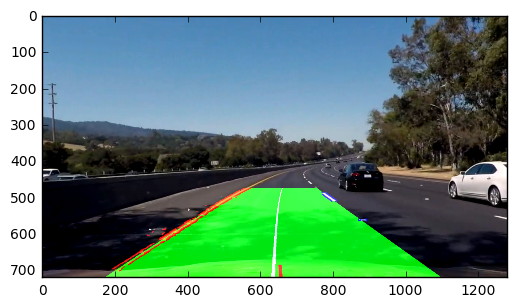

In [25]:
# Plot the image-result
plt.imshow(result)

In [26]:
# Plotting just the back_transformed found lane-lines
Minv = cv2.getPerspectiveTransform(dst,src)
new_img = np.zeros_like(img_img[6])
new_img[img_img[3][img_img[4]], img_img[2][img_img[4]]] = [255, 0, 0]
new_img[img_img[3][img_img[5]], img_img[2][img_img[5]]] = [0, 0, 255]
back_warped = cv2.warpPerspective(new_img, Minv, img_size, flags = cv2.INTER_LINEAR)

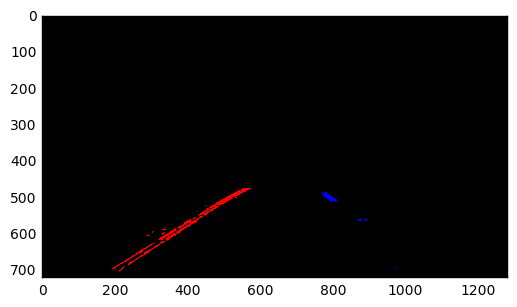

In [27]:
plt.imshow(back_warped)

In [28]:
# Using the formula shown in the lessons to get the curvatures in meters as well as the distance between the middle of the picture 
# and the middle between the lines
left_curverad = ((1 + (2*img_hist[0][0]*359 + img_hist[0][1])**2)**1.5) / np.absolute(2*img_hist[0][0])
right_curverad = ((1 + (2*img_hist[1][0]*359 + img_hist[1][1])**2)**1.5) / np.absolute(2*img_hist[1][0])

In [29]:
ym_per_pix = 30/720
xm_per_pix = 3.7/700

left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

left_curverad = ((1 + (2*left_fit_cr[0]*359*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*359*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

print((left_curverad+right_curverad)/2, 'm')
print(mid_distance*xm_per_pix, 'm')

3953.1514533 m
-0.0918908339452 m


In [30]:
# Defining a function to measure this for the video
def measure(left_fitx, right_fitx, mid_fitx, ym_per_pix = 30/720, xm_per_pix=3.7/700):
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*359*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*359*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curve = (left_curverad+right_curverad)/2
    mid_distance = mid_fitx[-1]-(1280/2-1)
    dist = mid_distance*xm_per_pix
    return curve, dist

In [31]:
# Setting up some variables to use for the function process_image
actual_lane = None
actual_lanes = []
sanity_counter = 4
counter_hist = 0
counter_img = 0

In [32]:
# We are using all functions from before to get all information we need and put a result out for
# each frame in the video
def process_image(image):
    global sanity_counter
    global actual_lane
    global counter_hist
    global counter_img
    
    # Undistort - binary_picture - warping
    undist = cv2.undistort(image, mtx, dist)
    dir_image = dir_threshold(undist, sobel_kernel=17, thresh=(0.4, 1.4))
    mag_image = mag_threshold(undist, sobel_kernel=17, thresh=(35, 255))
    hls_image = hls_threshold(undist, thresh=(150, 255))
    hls2_image = hls_threshold2(undist, thresh=(100, 255))
    
    combined = np.zeros_like(dir_image)
    combined[((dir_image == 1) & (mag_image == 1)) | (hls_image == 1) & (hls2_image == 1)] = 1
    
    warped = cv2.warpPerspective(combined, M, img_size, flags = cv2.INTER_LINEAR)
    
    binary = np.where(warped>0)
    warped[binary] = 1
    
    # Use sanity_counter to choose when to use histogram search of image search
    if (sanity_counter <= 3):
        
        # Choosing Search_lines_with_image
        img_hist = Search_lines_with_image(warped, actual_lane[0], actual_lane[1], actual_lane[2], actual_lane[3])
        if (1 >= counter_hist+counter_img <= 50):
            Draw_lines_with_image(warped, img_hist[0], img_hist[1], img_hist[2], img_hist[3], img_hist[4], img_hist[5], img_hist[6], img_hist[7], img_hist[8])
        
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = img_hist[0][0]*ploty**2 + img_hist[0][1]*ploty + img_hist[0][2]
        right_fitx = img_hist[1][0]*ploty**2 + img_hist[1][1]*ploty + img_hist[1][2]
        mid_fitx = ((img_hist[0][0]+img_hist[1][0])/2)*ploty**2+((img_hist[0][1]+img_hist[1][1])/2)*ploty+((img_hist[0][2]+img_hist[1][2])/2)
        
        # Smoothing the measurement with the last up to two images before the actual picture
        if len(actual_lanes) != 0:
            numpy_lane = np.asarray(actual_lanes)
            numpy_lane = np.sum(numpy_lane, axis = 0)    
            left_fitx = (left_fitx + numpy_lane[0][0]*ploty**2 + numpy_lane[0][1]*ploty + numpy_lane[0][2])/(len(actual_lanes)+1)
            right_fix = (right_fitx + numpy_lane[1][0]*ploty**2 + numpy_lane[1][1]*ploty + numpy_lane[1][2])/(len(actual_lanes)+1)
            mid_fitx = (mid_fitx + ((numpy_lane[0][0]+numpy_lane[1][0])/2)*ploty**2+((numpy_lane[0][1]+numpy_lane[1][1])/2)*ploty+((numpy_lane[0][2]+numpy_lane[1][2])/2))/(len(actual_lanes)+1)
        
        # Printing everything on the image
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        mid_window1 = np.array([np.transpose(np.vstack([mid_fitx-4, ploty]))])
        mid_window2 = np.array([np.flipud(np.transpose(np.vstack([mid_fitx+4, ploty])))])
        mid_window = np.hstack((mid_window1, mid_window2))
        
        test_1 = np.dstack((warped, warped, warped))*255
        test_1 = cv2.convertScaleAbs(test_1)

        cv2.fillPoly(test_1, np.int_([pts]), (0,255,0))
        cv2.fillPoly(test_1, np.int_([mid_window]), (255,255,255))
        cv2.rectangle(test_1, (int(1280/2-5), 719), (int(1280/2+3), 700), (255, 0, 0), -1)
        
        test_1[img_hist[3][img_hist[4]], img_hist[2][img_hist[4]]] = [255, 0, 0]
        test_1[img_hist[3][img_hist[5]], img_hist[2][img_hist[5]]] = [0, 0, 255]

        # measure distance and curvature
        meas = measure(left_fitx, right_fitx, mid_fitx)
        
        # warping back
        Minv = cv2.getPerspectiveTransform(dst,src)
        back_warped = cv2.warpPerspective(test_1, Minv, img_size, flags = cv2.INTER_LINEAR)
        
        curve_check = right_fitx[359]-left_fitx[359]
        curve_check = right_fitx-curve_check
        curve_check = np.sum(np.abs(left_fitx-curve_check))/left_fitx.shape[0]

        distance_check = np.abs((639-left_fitx[719])-(right_fitx[719]-639))

        result = cv2.addWeighted(undist, 1, back_warped, 0.9, 0)
        text = 'distance from mid: '+str(meas[1])+'m' + ', curveradius: ' +str(meas[0])+'m'
        result = cv2.putText(result, text, (15, 15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255), 2)
        
        counter_img = counter_img + 1
        
        #sanity-check
        if (img_hist[4].shape[0] > 15000) & (img_hist[5].shape[0] > 15000) & (distance_check <= 120) & (curve_check <= 20):
            sanity_counter = 0
            actual_lane = img_hist[0], img_hist[1], img_hist[2], img_hist[3]
            actual_lanes.append([img_hist[0], img_hist[1]])
            if len(actual_lanes) >= 3:
                actual_lanes.pop(0)
        else:
            sanity_counter = sanity_counter+1
        
    else:
        # Choosing Search_lines_with_histogram
        # Everything else like before
        img_hist = Search_lines_with_histogram(warped)
        if (1 >= counter_hist+counter_img >= 50):
            Draw_lines_with_histogram(warped, img_hist[0], img_hist[1], img_hist[2], img_hist[3], img_hist[4], img_hist[5], img_hist[6])
        
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = img_hist[0][0]*ploty**2 + img_hist[0][1]*ploty + img_hist[0][2]
        right_fitx = img_hist[1][0]*ploty**2 + img_hist[1][1]*ploty + img_hist[1][2]
        mid_fitx = ((img_hist[0][0]+img_hist[1][0])/2)*ploty**2+((img_hist[0][1]+img_hist[1][1])/2)*ploty+((img_hist[0][2]+img_hist[1][2])/2)
        
        if len(actual_lanes) != 0:
            numpy_lane = np.asarray(actual_lanes)
            numpy_lane = np.sum(numpy_lane, axis = 0)    
            left_fitx = (left_fitx + numpy_lane[0][0]*ploty**2 + numpy_lane[0][1]*ploty + numpy_lane[0][2])/(len(actual_lanes)+1)
            right_fix = (right_fitx + numpy_lane[1][0]*ploty**2 + numpy_lane[1][1]*ploty + numpy_lane[1][2])/(len(actual_lanes)+1)
            mid_fitx = (mid_fitx + ((numpy_lane[0][0]+numpy_lane[1][0])/2)*ploty**2+((numpy_lane[0][1]+numpy_lane[1][1])/2)*ploty+((numpy_lane[0][2]+numpy_lane[1][2])/2))/(len(actual_lanes)+1)
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        mid_window1 = np.array([np.transpose(np.vstack([mid_fitx-4, ploty]))])
        mid_window2 = np.array([np.flipud(np.transpose(np.vstack([mid_fitx+4, ploty])))])
        mid_window = np.hstack((mid_window1, mid_window2))
        
        test_1 = np.dstack((warped, warped, warped))*255
        test_1 = cv2.convertScaleAbs(test_1)

        cv2.fillPoly(test_1, np.int_([pts]), (0,255,0))
        cv2.fillPoly(test_1, np.int_([mid_window]), (255,255,255))
        cv2.rectangle(test_1, (int(1280/2-5), 719), (int(1280/2+3), 700), (255, 0, 0), -1)
        
        test_1[img_hist[3][img_hist[4]], img_hist[2][img_hist[4]]] = [255, 0, 0]
        test_1[img_hist[3][img_hist[5]], img_hist[2][img_hist[5]]] = [0, 0, 255]
        
        meas = measure(left_fitx, right_fitx, mid_fitx)
        
        Minv = cv2.getPerspectiveTransform(dst,src)
        back_warped = cv2.warpPerspective(test_1, Minv, img_size, flags = cv2.INTER_LINEAR)
        
        curve_check = right_fitx[359]-left_fitx[359]
        curve_check = right_fitx-curve_check
        curve_check = np.sum(np.abs(left_fitx-curve_check))/left_fitx.shape[0]

        distance_check = np.abs((639-left_fitx[719])-(right_fitx[719]-639))

        result = cv2.addWeighted(undist, 1, back_warped, 0.9, 0)
        text = 'distance from mid: '+str(meas[1])+'m' + ', curveradius: ' +str(meas[0])+'m'
        result = cv2.putText(result, text, (15, 15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255), 2)
        
        counter_hist = counter_hist + 1
            
        if (img_hist[4].shape[0] > 15000) & (img_hist[5].shape[0] > 15000) & (distance_check <= 120) & (curve_check <= 20):
            sanity_counter = 0
            actual_lane = img_hist[0], img_hist[1], img_hist[2], img_hist[3]
            actual_lanes.append([img_hist[0], img_hist[1]])
            if len(actual_lanes) >= 3:
                actual_lanes.pop(0)
        else:
            sanity_counter = sanity_counter+1
    return result

In [33]:
# Using the function on the project_video.mp4 and making a new video output.mp4
output_video = 'output.mp4'
clip1 = VideoFileClip('/media/frank/Zusatz/CarND-Advanced-Lane-Lines/project_video.mp4')

output_clip = clip1.fl_image(process_image)
%time output_clip.write_videofile(output_video, audio=False)

HTML("""
<video width="1280" height="720" controls>
   <source src="{0}">
<\video>
""".format(output_video))

/media/frank/Zusatz/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file output.mp4
----------------------------------------

Writing video into output.mp4
|----------| 0/1210   0% [elapsed: 00:00 left: ?, ? iters/sec]

/media/frank/Zusatz/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/media/frank/Zusatz/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


|----------| 1/1210   0% [elapsed: 00:00 left: 11:55,  1.69 iters/sec]

/media/frank/Zusatz/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/media/frank/Zusatz/anaconda3/envs/CarND-LeNet-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


                                                                         --------| 3/1210   0% [elapsed: 00:01 left: 12:01,  1.67 iters/sec]Done writing video in output.mp4 !
Your video is ready !
CPU times: user 44min 4s, sys: 1min 12s, total: 45min 16s
Wall time: 12min 30s


In [35]:
# How often did we use the histogram-search
print(str(counter_hist/(counter_img+counter_hist))+'%')

0.1948802642444261%
